Class Distribution: Counter({0: 681, 1: 146})
Original dims: 9000, Reduced to: 214
Explained variance: 0.9900
Balanced class distribution (train): Counter({0: 544, 1: 544})
K=3: Accuracy=0.5000, Precision=0.2065, Recall=0.6552, F1=0.3140, Specificity=0.4672, AUC=0.5930
K=4: Accuracy=0.5482, Precision=0.2262, Recall=0.6552, F1=0.3363, Specificity=0.5255, AUC=0.6021
K=5: Accuracy=0.5000, Precision=0.2128, Recall=0.6897, F1=0.3252, Specificity=0.4599, AUC=0.6021
K=6: Accuracy=0.5181, Precision=0.2069, Recall=0.6207, F1=0.3103, Specificity=0.4964, AUC=0.6058
K=7: Accuracy=0.5181, Precision=0.2198, Recall=0.6897, F1=0.3333, Specificity=0.4818, AUC=0.6157
K=8: Accuracy=0.5181, Precision=0.2135, Recall=0.6552, F1=0.3220, Specificity=0.4891, AUC=0.6306
K=9: Accuracy=0.5120, Precision=0.2234, Recall=0.7241, F1=0.3415, Specificity=0.4672, AUC=0.6319
K=10: Accuracy=0.4940, Precision=0.2165, Recall=0.7241, F1=0.3333, Specificity=0.4453, AUC=0.6281
K=11: Accuracy=0.4759, Precision=0.2157, Recall=0.

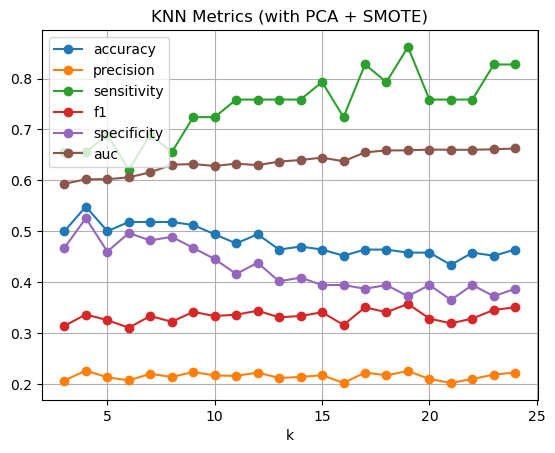

In [2]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load dataset
data_path = r'E:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\ecg_data.csv'
data = pd.read_csv(data_path, index_col=0)

# Split features and labels
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Check class distribution
print("Class Distribution:", Counter(y))

# Scale features
scaler = RobustScaler(quantile_range=(30, 70))
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=7, stratify=y
)

# Apply PCA
pca = PCA(n_components=0.99)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Original dims: {X.shape[1]}, Reduced to: {X_train_pca.shape[1]}")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.4f}")

# Apply SMOTE to balance training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_pca, y_train)

print("Balanced class distribution (train):", Counter(y_train_bal))

# Store results
results = []

# Try multiple k values
for k in range(3, 25):
    model = KNeighborsClassifier(n_neighbors=k, weights='distance')
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test_pca)
    y_pred_proba = model.predict_proba(X_test_pca)[:, 1]  # Probability for positive class

    # Metrics calculation
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)  # AUC

    cm = confusion_matrix(y_test, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) else 0
    else:
        specificity = np.nan

    print(f"K={k}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, Specificity={specificity:.4f}, AUC={auc:.4f}")
    results.append({'k': k, 'accuracy': acc, 'precision': prec, 'sensitivity': rec, 'f1': f1, 'specificity': specificity, 'auc': auc})

# Plot results
df_results = pd.DataFrame(results)
df_results.plot(x='k', y=['accuracy', 'precision', 'sensitivity', 'f1', 'specificity', 'auc'], marker='o')
plt.title("KNN Metrics (with PCA + SMOTE)")
plt.grid(True)
plt.show()
